In [15]:
from yaml import safe_load
from itertools import product
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
import math

from einops import rearrange
from typing import Any

warnings.simplefilter("ignore", (UserWarning, FutureWarning))

In [47]:
def infer_dataset(config: dict[str, Any]) -> str:
    datamodule = config["datamodule"]["_target_"]
    if "ECG" in datamodule:
        return "ECG"
    if "MIMICIII" in datamodule:
        return "MIMIC-III"
    if "NASDAQ" in datamodule:
        return "NASDAQ-2019"
    if "Droughts" in datamodule:
        return "US-Droughts"
    if "NASA" in datamodule:
        if config["datamodule"]["subdataset"] == "charge":
            return "NASA-Charge"
        else:
            return "NASA-Discharge"


def infer_diffusion_domain(fourier_transform: bool) -> str:
    if fourier_transform:
        return "Frequency"
    else:
        return "Time"


def calculate_metrics(results: dict) -> list[dict]:
    data = []
    for domain, method in product({"time", "freq"}, {"sliced", "marginal"}):
        all_distances = results[f"{domain}_{method}_wasserstein_all"]
        data.extend(
            [
                {
                    "Value": distance,
                    "Metric Domain": "Frequency" if domain == "freq" else "Time",
                    "Metric": "Sliced Wasserstein"
                    if method == "sliced"
                    else "Marginal Wasserstein",
                }
                for distance in all_distances
            ]
        )
    return data


def infer_tensor_shapes(sample_path: Path) -> tuple[int, int]:
    samples = torch.load(sample_path)
    return samples.shape[-2:]


def calculate_spectral_density(
    marginal_spectral: list[float], sample_path: Path
) -> list[float]:
    _, n_channels = infer_tensor_shapes(sample_path)
    marginal_spectral = torch.tensor(marginal_spectral)
    marginal_spectral = rearrange(
        marginal_spectral, "(freq channels) -> freq channels", channels=n_channels
    )
    return marginal_spectral.mean(dim=1)

In [17]:
run_list = [
    "wdwxc4fg",
    "amxdfaoo",
    "20d9c1kc",
    "j5l1t49d",
    "tip2g8eh",
    "pkjeomys",
    "qdzk36m7",
    "hxoxvper",
    "xxqse6xu",
    "na9xdfui",
    "bf3lrfx9",
    "emk7nyz3",
]
runs_dir = Path.cwd() / "../lightning_logs/"

# Sample Quality


In [18]:
df_list = []
for run in run_list:
    with open(runs_dir / f"{run}/train_config.yaml", "r") as f:
        config = safe_load(f)
        dataset = infer_dataset(config)
        domain = infer_diffusion_domain(config["fourier_transform"])
    with open(runs_dir / f"{run}/results.yaml", "r") as f:
        results = safe_load(f)
        df = pd.DataFrame(calculate_metrics(results))
        df["Dataset"] = dataset
        df["Diffusion Domain"] = domain
        df_list.append(df)
df = pd.concat(df_list)
df.head()

,Value,Metric Domain,Metric,Dataset,Diffusion Domain
0,0.205126,Time,Sliced Wasserstein,MIMIC-III,Frequency
1,0.110730,Time,Sliced Wasserstein,MIMIC-III,Frequency
2,0.158600,Time,Sliced Wasserstein,MIMIC-III,Frequency
3,0.142727,Time,Sliced Wasserstein,MIMIC-III,Frequency
4,0.075877,Time,Sliced Wasserstein,MIMIC-III,Frequency


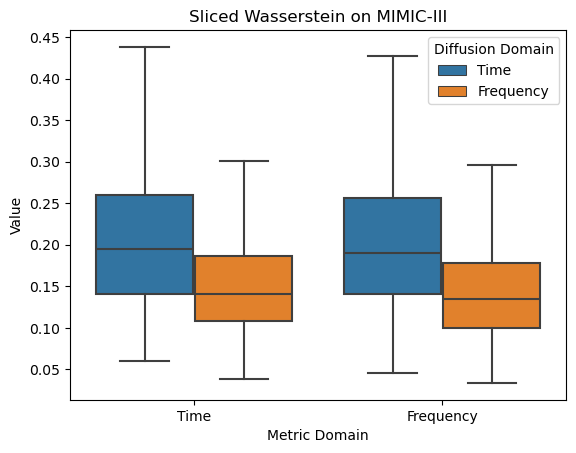

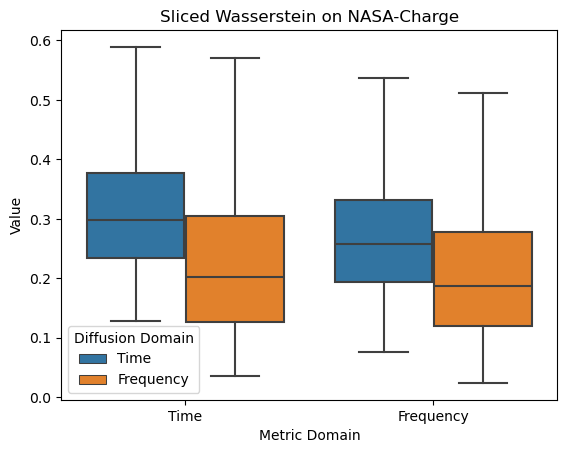

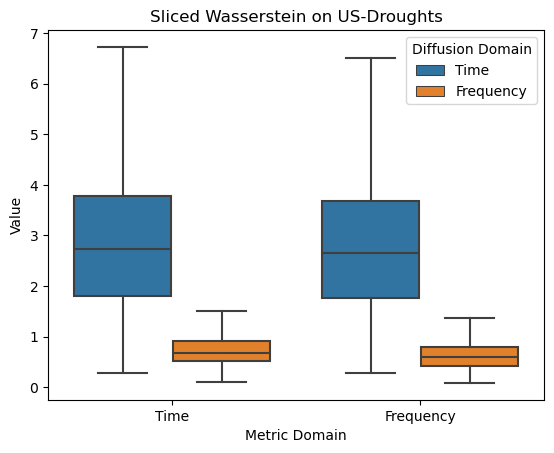

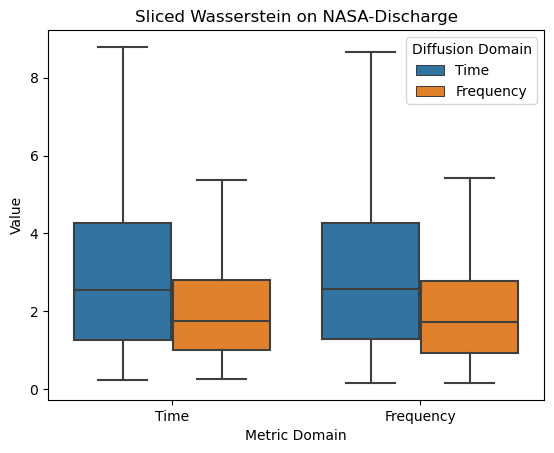

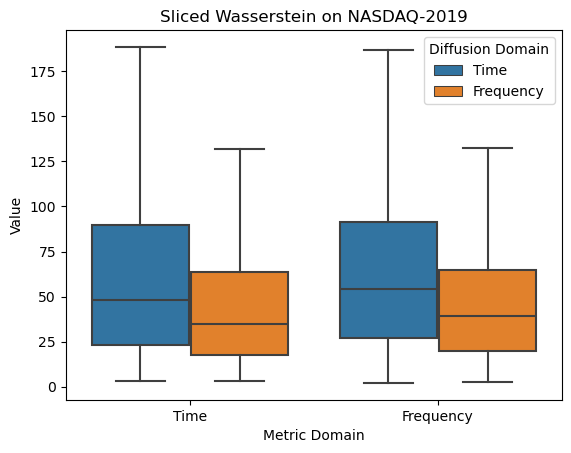

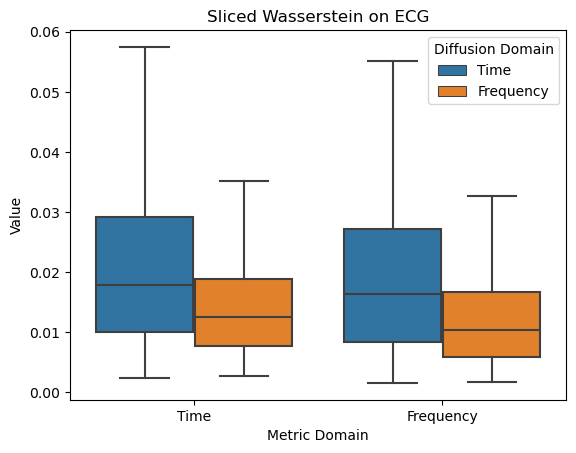

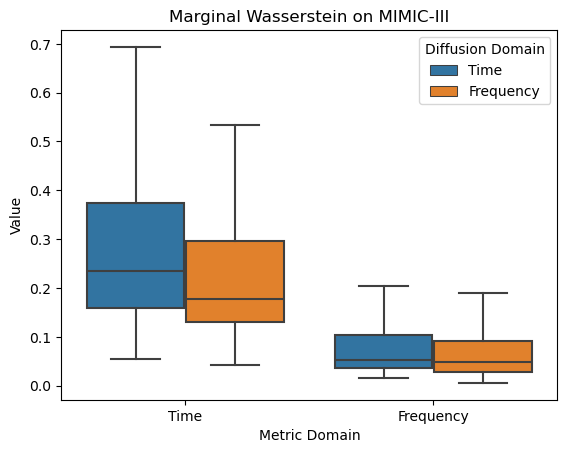

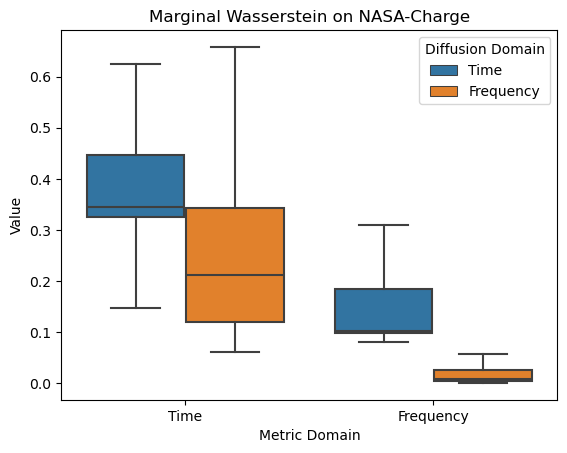

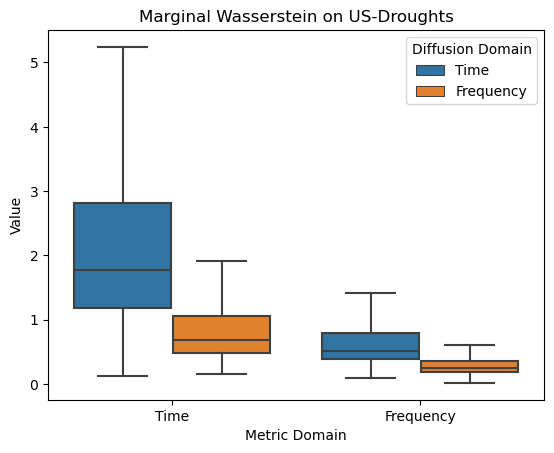

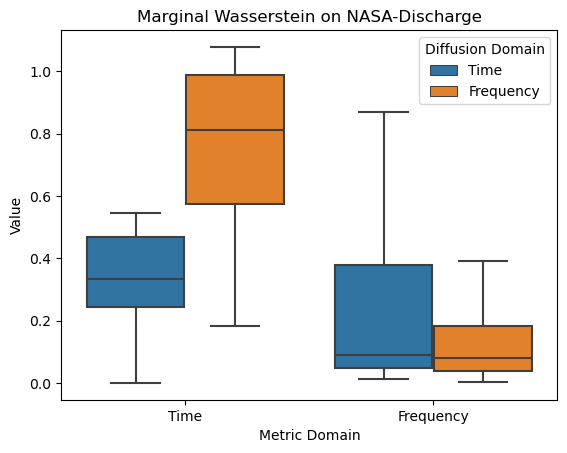

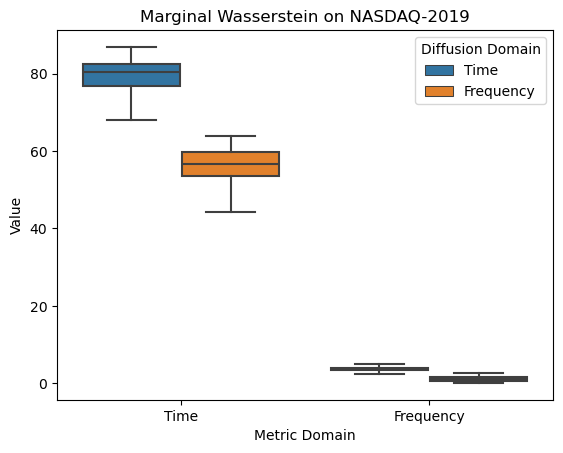

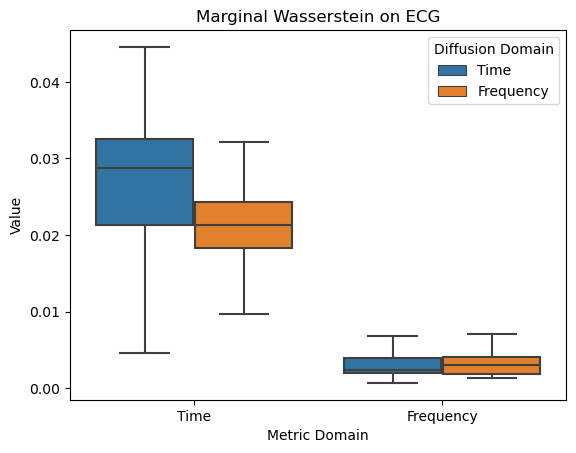

In [20]:
for metric in df.Metric.unique():
    for dataset in df.Dataset.unique():
        ax = sns.boxplot(
            data=df[(df.Metric == metric) & (df.Dataset == dataset)],
            x="Metric Domain",
            y="Value",
            hue="Diffusion Domain",
            hue_order=["Time", "Frequency"],
            showfliers=False,
        )
        plt.title(f"{metric} on {dataset}")
        plt.show()

In [81]:
aggfunc

pd.pivot_table(
    df,
    index=["Metric", "Metric Domain", "Dataset"],
    columns="Diffusion Domain",
    values="Value",
    aggfunc=["mean", "sem"],
)

mean             \
Diffusion Domain                                   Frequency       Time   
Metric               Metric Domain Dataset                                
Marginal Wasserstein Frequency     ECG              0.005271   0.006342   
                                   MIMIC-III        0.107816   0.131939   
                                   NASA-Charge      0.039613   0.158002   
                                   NASA-Discharge   0.314363   0.414461   
                                   NASDAQ-2019      5.531958   9.298016   
                                   US-Droughts      0.350524   0.772624   
                     Time          ECG              0.021478   0.027035   
                                   MIMIC-III        0.240933   0.287725   
                                   NASA-Charge      0.272547   0.394931   
                                   NASA-Discharge   1.590642   1.879825   
                                   NASDAQ-2019     55.863663  78.536881   
                                   US-Droughts      0.931252   2.562937   
Sliced Wasserstein   Frequency     ECG              0.012346   0.019637   
                                   MIMIC-III        0.144238   0.205911   
                                   NASA-Charge      0.210592   0.269792   
                                   NASA-Discharge   1.999046   2.974167   
                                   NASDAQ-2019     45.812442  64.056194   
                                   US-Droughts      0.632858   2.848746   
                     Time          ECG              0.014575   0.021442   
                                   MIMIC-III        0.151587   0.210880   
                                   NASA-Charge      0.229070   0.316152   
                                   NASA-Discharge   2.028113   2.941808   
                                   NASDAQ-2019     43.602172  60.512484   
                                   US-Droughts      0.737681   2.912747   

                                                        sem            
Diffusion Domain                                  Frequency      Time  
Metric               Metric Domain Dataset                             
Marginal Wasserstein Frequency     ECG             0.001072  0.001777  
                                   MIMIC-III       0.008106  0.009919  
                                   NASA-Charge     0.008195  0.009290  
                                   NASA-Discharge  0.093565  0.140743  
                                   NASDAQ-2019     1.571609  2.231156  
                                   US-Droughts     0.010120  0.048572  
                     Time          ECG             0.000329  0.000733  
                                   MIMIC-III       0.005573  0.005822  
                                   NASA-Charge     0.006240  0.005348  
                                   NASA-Discharge  0.074180  0.122275  
                                   NASDAQ-2019     0.137870  0.156430  
                                   US-Droughts     0.012072  0.032526  
Sliced Wasserstein   Frequency     ECG             0.000258  0.000447  
                                   MIMIC-III       0.001924  0.002796  
                                   NASA-Charge     0.003659  0.003160  
                                   NASA-Discharge  0.042498  0.067195  
                                   NASDAQ-2019     1.048308  1.519754  
                                   US-Droughts     0.009087  0.044758  
                     Time          ECG             0.000281  0.000456  
                                   MIMIC-III       0.001914  0.002867  
                                   NASA-Charge     0.004163  0.003512  
                                   NASA-Discharge  0.041157  0.066505  
                                   NASDAQ-2019     1.022119  1.480206  
                                   US-Droughts     0.009666  0.045754

# Spectral Analysis


In [75]:
spectral_data = []
for run in run_list:
    with open(runs_dir / f"{run}/train_config.yaml", "r") as f:
        config = safe_load(f)
        dataset_name = infer_dataset(config)
        diffusion_domain = infer_diffusion_domain(config["fourier_transform"])
    with open(runs_dir / f"{run}/results.yaml", "r") as f:
        results = safe_load(f)
        spectral_density = calculate_spectral_density(
            results["spectral_marginal_wasserstein_all"],
            sample_path=runs_dir / f"{run}/samples.pt",
        )
        freqs = torch.arange(0, 1, 1 / spectral_density.shape[0])
        spectral_data.extend(
            [
                {
                    "Dataset": dataset_name,
                    "Diffusion Domain": diffusion_domain,
                    "Frequency": freqs[k].item(),
                    "Spectral Density": spectral_density[k].item(),
                }
                for k in range(len(spectral_density))
            ]
        )
spectral_df = pd.DataFrame(spectral_data)
spectral_df.head()

,Dataset,Diffusion Domain,Frequency,Spectral Density
0,MIMIC-III,Frequency,0.000000,134.392731
1,MIMIC-III,Frequency,0.076923,8.906826
2,MIMIC-III,Frequency,0.153846,1.886092
3,MIMIC-III,Frequency,0.230769,0.968898
4,MIMIC-III,Frequency,0.307692,0.703204


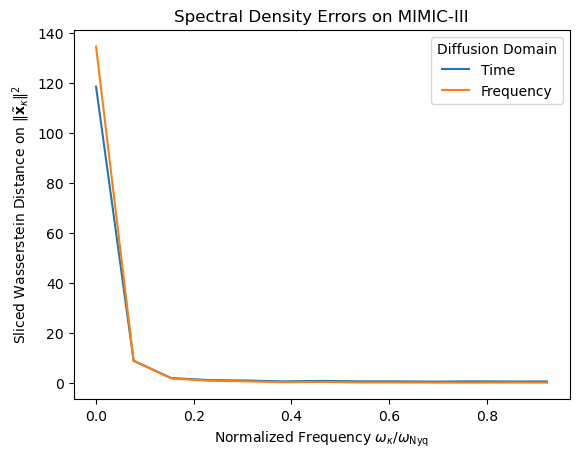

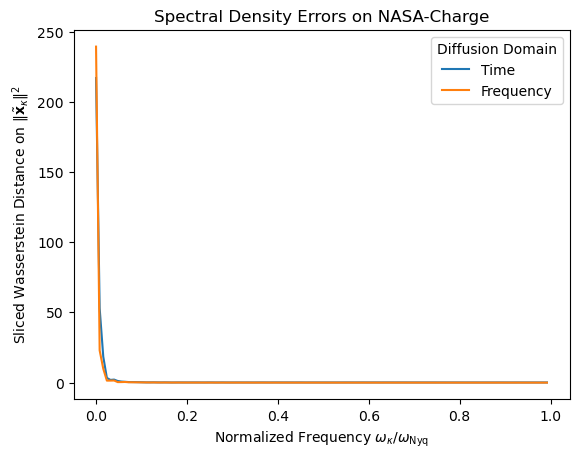

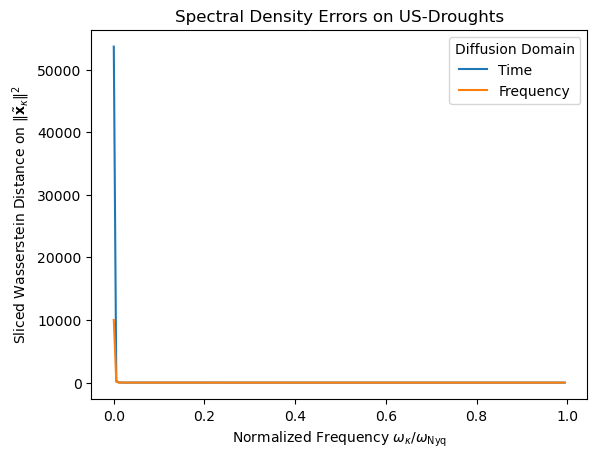

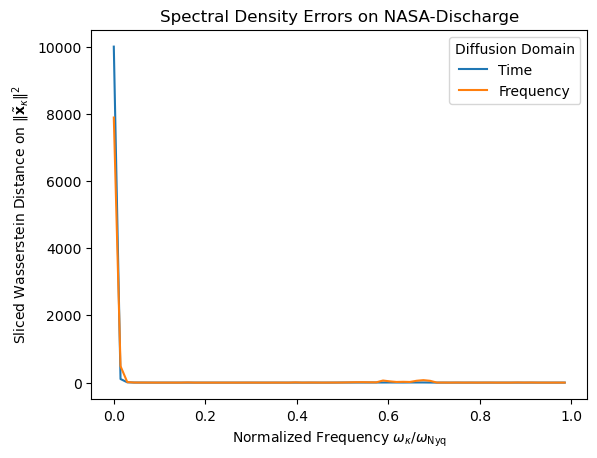

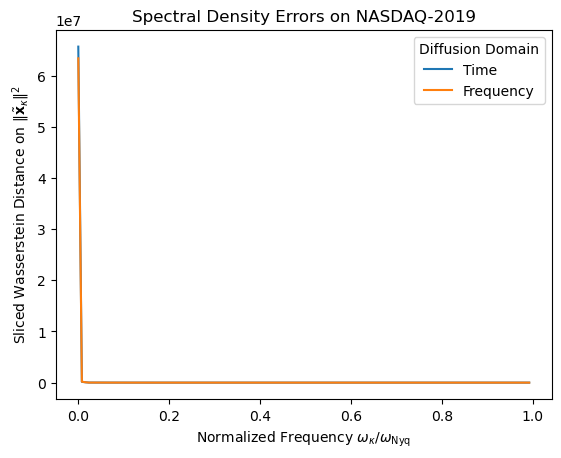

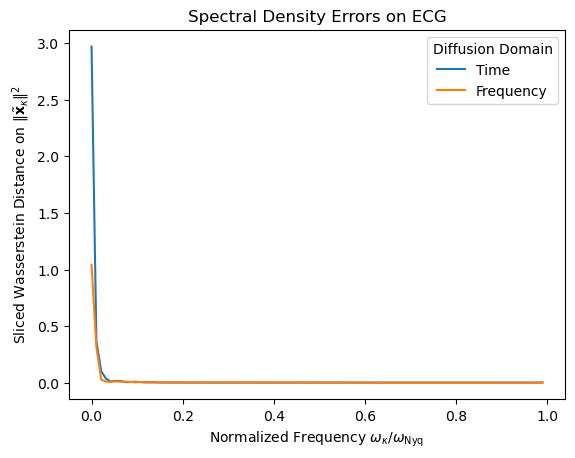

In [76]:
for dataset in spectral_df.Dataset.unique():
    ax = sns.lineplot(
        data=spectral_df[spectral_df.Dataset == dataset],
        x="Frequency",
        y="Spectral Density",
        hue="Diffusion Domain",
        hue_order=["Time", "Frequency"],
    )
    plt.title(f"Spectral Density Errors on {dataset}")
    plt.ylabel(r"Sliced Wasserstein Distance on $\|\tilde{\mathbf{x}}_\kappa \|^2$")
    plt.xlabel(r"Normalized Frequency $\omega_\kappa  /  \omega_{\mathrm{Nyq}}$")
    plt.show()